# 579 - A3
Meilin Lyu 260899756
Alexander Aleshchenko 260923564

In [1]:
import pandas
import numpy as np
import gymnasium as gym
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'sklearn'

## Load Data

In [ ]:
def load_data(file_path):
    data = pandas.read_csv(file_path, index_col=False)
    return data

np.set_printoptions(edgeitems=30)
# expert_100 = np.genfromtxt('expert_100.csv', delimiter=',')[1:-1]
# expert_100_im = load_data('expert_100.csv')


## Discretization and One-Hot Encoding helper functions

dimension of state: num_data by 40

In [ ]:
def one_hot(s1, s2, s3, s4):
    a = np.array([s1, s2, s3, s4])
    b = np.zeros((a.size, 10))
    b[np.arange(a.size), a] = 1
    return b.reshape(-1)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def getBin(s, intervals):
    for i in range(len(intervals)):
        if intervals[i].left <= s <= intervals[i].right:
            return i
    return 0

## Simple Imitation learning - using Logistic Regression

In [ ]:
def simple_imitation(data):
    data_ac = data[["state_0", "state_1", "state_2", "state_3"]]
    action_data_ac = data[["action_count"]]

    X = data_ac
    y = action_data_ac
    #using logistic regression to fit data
    clf = LogisticRegression(random_state=1).fit(X.values, y.values.reshape(len(y),))

    env = gym.make("CartPole-v1")
    rewards = []
    for episode in range(100):
        state, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            #print(state)
            #predicting
            action = clf.predict([state])
            next_state, reward, done, _, _ = env.step(action[0])
            state = next_state
            total_reward += reward
        rewards.append(total_reward)
    return np.mean(rewards), np.std(rewards)

## Fitted_Q Learning

In [ ]:
def update(state, action, reward, next_state, weights, lr=0.00001):
    pred_next = next_state.dot(weights) # evaluating Q, (n x 40) dot (40 x 2) gives (n x 2)
    max_v = np.max(pred_next) # n x 1 where each entry is max Q value of that row
    y = reward + 0.99*max_v # n x 1
    temp = state.dot(weights) # n x 2
    q = np.array([temp[i][action[i]] for i in range(len(action))]) # n x 1
    gradient = np.reshape(q-y, (len(state), 1))*state
    for i in range(len(state)):
        #gradient descent
        weights[:,action[i]] -= lr*gradient[i]

def fitted_q(data, do_sigmoid = True, lr = 0.00001, k=7):
    actions = np.array(data[:,4]).astype(int)
    rewards = data[:,9]

    #do_sigmoid = True
    #since most of the states fall into a small subset of the bins, we use sigmoid to spread the states evenly across bins
    if (do_sigmoid):
        data[:,0] = np.vectorize(sigmoid)(data[:,0])
        data[:,1] = np.vectorize(sigmoid)(data[:,1])
        data[:,2] = np.vectorize(sigmoid)(data[:,2])
        data[:,3] = np.vectorize(sigmoid)(data[:,3])

        data[:,5] = np.vectorize(sigmoid)(data[:,5])
        data[:,6] = np.vectorize(sigmoid)(data[:,6])
        data[:,7] = np.vectorize(sigmoid)(data[:,7])
        data[:,8] = np.vectorize(sigmoid)(data[:,8])
    #discretization
    s1 = pandas.qcut(data[:,0], 10, labels=range(0,10))
    s2 = pandas.qcut(data[:,1], 10, labels=range(0,10))
    s3 = pandas.qcut(data[:,2], 10, labels=range(0,10))
    s4 = pandas.qcut(data[:,3], 10, labels=range(0,10))
    states_onehot = np.array([one_hot(s1[i], s2[i], s3[i], s4[i]) for i in range(len(s1))]) # rows x

    s1_cat = pandas.qcut(data[:,0], 10)
    s2_cat = pandas.qcut(data[:,1], 10)
    s3_cat = pandas.qcut(data[:,2], 10)
    s4_cat = pandas.qcut(data[:,3], 10)

    nx1 = pandas.qcut(data[:,5], 10, labels=range(0,10))
    nx2 = pandas.qcut(data[:,6], 10, labels=range(0,10))
    nx3 = pandas.qcut(data[:,7], 10, labels=range(0,10))
    nx4 = pandas.qcut(data[:,8], 10, labels=range(0,10))
    nextstates_onehot = np.array([one_hot(nx1[i], nx2[i], nx3[i], nx4[i]) for i in range(len(s1))])
    #random initialization of weights
    weights = np.random.uniform(-0.001, 0.001, (40,2))

    #iterations
    #k = 5
    for i in range(k):
        update(states_onehot, actions, rewards, nextstates_onehot, weights, lr)

    env = gym.make("CartPole-v1")
    rewards = []
    for episode in range(100):
        state, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            if (do_sigmoid):
                state = np.vectorize(sigmoid)(state)
            #discretizing state value received from the environment
            b1 = getBin(state[0], s1_cat.categories)
            b2 = getBin(state[1], s2_cat.categories)
            b3 = getBin(state[2], s3_cat.categories)
            b4 = getBin(state[3], s4_cat.categories)
            state = one_hot(b1,b2,b3,b4)

            action = np.argmax(state.dot(weights))
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            total_reward += reward

        rewards.append(total_reward)
    return np.mean(rewards), np.std(rewards)

In [ ]:
from sklearn.neural_network import MLPClassifier

def mlp(data):
    data_ac = data[["state_0", "state_1", "state_2", "state_3"]]
    action_data_ac = data[["action_count"]]

    X = data_ac
    y = action_data_ac
    clf = MLPClassifier(random_state=1, max_iter=500).fit(X.values, y.values.reshape(len(y),))

    env = gym.make("CartPole-v1")
    rewards = []
    for episode in range(100):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            if type(state) is tuple:
                state = state[0]
            action = clf.predict([state])
            next_state, reward, done, _, _ = env.step(action[0])
            state = next_state
            total_reward += reward
        rewards.append(total_reward)
    return np.mean(rewards), np.std(rewards)

Comparing learning rates and iteration for fitted_Q learning
Experiment shows learning rate of 0.00001 and iteration 7 yields best result.
Each row represents a different learning rate
Each column represents a different iteration (K) value

In [ ]:
data = np.genfromtxt("expert_250.csv", delimiter=',')[1:-1]
lrs = [0.000005, 0.00001, 0.0005]
ks = [4,7,10]
results = np.zeros((len(lrs),len(ks)))
for i in range(len(lrs)):
    for j in range(len(ks)):
        data_test = np.copy(data)
        mean, _ = fitted_q(data_test, True, lrs[i], ks[j])
        results[i,j] = mean

print(results)

[[159.73 171.23 164.62]
 [171.41 185.22 176.37]
 [132.8    9.4    9.32]]


## Plotting Results

expert_500 Simple Imitation mean:  223.44
expert_500 Simple Imitation standard_deviation:  55.601676233725186
expert_500 Fitted Q mean: 182.56
expert_500 Fitted Q standard_deviation: 45.27434593674435
expert_250 Simple Imitation mean:  215.85
expert_250 Simple Imitation standard_deviation:  53.54425739516797
expert_250 Fitted Q mean: 169.77
expert_250 Fitted Q standard_deviation: 32.71539545840765
expert_100 Simple Imitation mean:  208.33
expert_100 Simple Imitation standard_deviation:  53.633395380117406
expert_100 Fitted Q mean: 185.29
expert_100 Fitted Q standard_deviation: 60.980045096736355
mixed_500 Simple Imitation mean:  223.81
mixed_500 Simple Imitation standard_deviation:  72.90674797301001
mixed_500 Fitted Q mean: 250.51
mixed_500 Fitted Q standard_deviation: 445.32937237509947
mixed_250 Simple Imitation mean:  207.28
mixed_250 Simple Imitation standard_deviation:  50.76023640606888
mixed_250 Fitted Q mean: 189.01
mixed_250 Fitted Q standard_deviation: 45.52636488893001
mixe

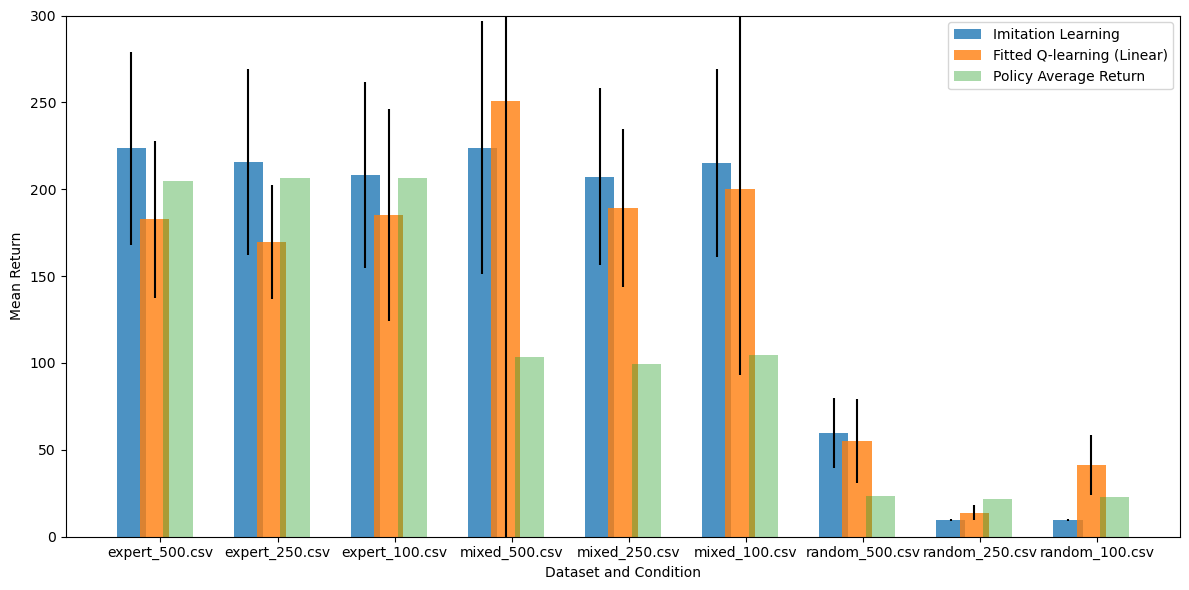

In [ ]:
simp_means = []
simp_stdvs = []
fq_means = []
fq_stdvs = []
fq_mlp_means = []
fq_mlp_stdvs = []
csvs = ["expert_500.csv", "expert_250.csv","expert_100.csv","mixed_500.csv", "mixed_250.csv","mixed_100.csv", "random_500.csv", "random_250.csv", "random_100.csv"]
original_means = []
for csv in csvs:
    data = np.genfromtxt(csv, delimiter=',')[1:-1]
    data_im = load_data(csv)
    simp_mean, simp_stdv = simple_imitation(data_im)
    simp_means.append(simp_mean)
    simp_stdvs.append(simp_stdv)
    print(f"{csv[:-4]} Simple Imitation mean:  {simp_mean}")
    print(f"{csv[:-4]} Simple Imitation standard_deviation:  {simp_stdv}")
    fq_mean, fq_stdv = fitted_q(data)
    fq_means.append(fq_mean)
    fq_stdvs.append(fq_stdv)
    print(f"{csv[:-4]} Fitted Q mean: {fq_mean}")
    print(f"{csv[:-4]} Fitted Q standard_deviation: {fq_stdv}")
    fq_mlp_mean, fq_mlp_stdv = mlp(data_im)
    fq_mlp_means.append(fq_mlp_mean)
    fq_mlp_stdvs.append(fq_mlp_stdv)
    print(f"{csv[:-4]} MLP mean: {fq_mlp_mean}")
    print(f"{csv[:-4]} MLP standard_deviation: {fq_mlp_stdv}")
    avg_mean = len(data)/float(csv[-7:-4])
    original_means.append(avg_mean)


# def addlabels(x,y):
#     for i in range(len(x)):
#         plt.text(i,y[i],y[i])

n_datasets = len(csvs)
bar_width = 0.25
opacity = 0.8
plt.figure(figsize = (12,6))
index = np.arange(n_datasets)

plt.bar(index, simp_means, bar_width, alpha=opacity, yerr=simp_stdvs, label="Imitation Learning")
plt.bar(index+0.2, fq_means, bar_width, alpha=opacity, yerr=fq_stdvs,
        label="Fitted Q-learning (Linear)")
plt.bar(index+0.4, fq_mlp_means, bar_width, alpha=opacity, yerr=fq_mlp_stdvs, label="Fitted Q-learning (MLP)")
plt.bar(index+0.4, original_means, bar_width, alpha=0.4, label="Policy Average Return")
#addlabels(csvs, simp_means)
plt.xlabel("Dataset and Condition")
plt.ylabel("Mean Return")
plt.ylim((0,300))
plt.xticks(index + bar_width,csvs)
plt.legend()
plt.tight_layout()
plt.show()

## Report

Our experiment compares two offline RL approaches - imitation learning and fitted_q learning, benchmarked on gymnasium's cart_pole environment. The datasets used are generated by running expert policy for 500 episodes and random policy for 500 episodes, generating 500 episodes of half expert and half random policy data, then choose from each of them 100, 250, and 500 episodes of data to make 9 datasets.

In imitation learning, we fit the data using a logistic regression model and use the fitted model to predict next action given a state value from the environment. In fitted_q learning, we use gradient descend to iteratively update the 40*2 weight table we initialized and predict the one-hot encoded state values of dimension n*40 by performing a matrix multiplication between the two. We then compute the gradient of the SSE loss and update the weights in the opposite direction of the gradient by a learning rate. We decide to train the function approximizer k = 7 iterations using learning rate of 0.00001. In our experiment, we chose k based on trial and error, but another approach to decide when to stop training is if the update in weight is smaller than some epsilon, which shows there is no significant improvement in the training.

We observe that when using expert-only data, imitation learning outperforms the original data while fitted_q learning performs worse. The size of the dataset also appears to have little to no impact on the outcome of the training. We observe that although half of the episode data in the mixed datasets are from a random policy, the performance of the models are on par with models trained using only expert data. We believe the random data acts as a regularizer that prevents the model from overfitting, thus leading to better performance on unseen data. Random policy performs the worst as it has no expert input to learn any meaningful behavior.